In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Analyse Noise Complaints in NYC

## Load Libraries

In [2]:
pip install pyglet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import geoplotlib.core
from scipy.ndimage import gaussian_filter
from geoplotlib.layers import KDELayer, BatchPainter


In [4]:
import pandas as pd
import numpy as np
import base64
import time
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import matplotlib.pyplot as plt
%matplotlib inline

## Load the filtered dataset

In [5]:
# Load it into a Dataframe using pandas
path = 'noise_data.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Location_Type,Complaint_Type,City,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location,Created_Date_date_time,year,month
0,0,52494258,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,The Police Department responded to the complai...,11/13/2021 12:01:53 AM,10009.0,MANHATTAN,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",2021-11-12 23:32:03,2021,11
1,1,52494267,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,RIDGEWOOD,The Police Department responded to the complai...,11/13/2021 02:07:28 AM,11385.0,QUEENS,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",2021-11-12 22:51:56,2021,11
2,2,52494269,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,The Police Department responded to the complai...,11/12/2021 10:46:20 PM,10012.0,MANHATTAN,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",2021-11-12 21:52:21,2021,11
3,3,52762434,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BRONX,The Police Department reviewed your complaint ...,12/10/2021 11:16:21 PM,10456.0,BRONX,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",2021-12-10 23:07:33,2021,12
4,6,47668843,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,BRONX,The Police Department responded to the complai...,09/24/2020 02:13:29 AM,10456.0,BRONX,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)",2020-09-24 00:53:51,2020,9


In [6]:
df.columns


Index(['Unnamed: 0', 'Unique_Key', 'Created_Date', 'Closed_Date', 'Agency',
       'Agency_Name', 'Descriptor', 'Location_Type', 'Complaint_Type', 'City',
       'Resolution_Description', 'Resolution_Action_UpdatedDate', 'zipcode',
       'Borough', 'Latitude', 'Longitude', 'Location',
       'Created_Date_date_time', 'year', 'month'],
      dtype='object')

In [7]:
df[['Created_Date','Closed_Date','Agency','Complaint_Type','Location_Type','Descriptor','City','Borough','Latitude','Longitude']]

,Created_Date,Closed_Date,Agency,Complaint_Type,Location_Type,Descriptor,City,Borough,Latitude,Longitude
0,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,Noise - Street/Sidewalk,Street/Sidewalk,Loud Music/Party,NEW YORK,MANHATTAN,40.728098,-73.980986
1,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,Noise - Residential,Residential Building/House,Loud Music/Party,RIDGEWOOD,QUEENS,40.703420,-73.910624
2,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,Noise - Street/Sidewalk,Street/Sidewalk,Loud Music/Party,NEW YORK,MANHATTAN,40.727491,-74.002594
3,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,Noise - Residential,Residential Building/House,Banging/Pounding,BRONX,BRONX,40.838195,-73.911184
4,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,Noise - Residential,Residential Building/House,Loud Music/Party,BRONX,BRONX,40.834562,-73.915424
...,...,...,...,...,...,...,...,...,...,...
788875,05/20/2020 01:41:49 AM,05/20/2020 02:00:52 AM,NYPD,Noise - Residential,Residential Building/House,Banging/Pounding,BROOKLYN,BROOKLYN,40.613541,-74.027175
788876,11/06/2021 10:38:00 PM,11/06/2021 10:45:30 PM,NYPD,Noise - Vehicle,Street/Sidewalk,Car/Truck Music,BRONX,BRONX,40.838626,-73.913829
788877,11/12/2021 07:34:30 PM,11/12/2021 08:54:07 PM,NYPD,Noise - Residential,Residential Building/House,Loud Talking,BRONX,BRONX,40.840586,-73.854331
788878,11/13/2021 12:19:08 AM,11/13/2021 01:38:54 AM,NYPD,Noise - Residential,Residential Building/House,Loud Talking,CORONA,QUEENS,40.751604,-73.867829


In [8]:
df.columns


Index(['Unnamed: 0', 'Unique_Key', 'Created_Date', 'Closed_Date', 'Agency',
       'Agency_Name', 'Descriptor', 'Location_Type', 'Complaint_Type', 'City',
       'Resolution_Description', 'Resolution_Action_UpdatedDate', 'zipcode',
       'Borough', 'Latitude', 'Longitude', 'Location',
       'Created_Date_date_time', 'year', 'month'],
      dtype='object')

## Data manging on the filtered dataset

> Create functions

In [9]:
# Create a function that gets the year of a datetime string
def getYear(s):
    first_split = s.split(' ')[0]
    return int(first_split.split('/')[-1])

In [10]:
# Create function that calculates the time diff in minutes between created and closed date
def getCallDuration(created, closed):
    # Assign format and type
    time_format = "%m/%d/%Y %I:%M:%S %p"
    created_date = datetime.strptime(created, time_format)
    closed_date = datetime.strptime(closed, time_format)
    
    # Convert to unix timestamp
    created_date = time.mktime(created_date.timetuple())
    closed_date = time.mktime(closed_date.timetuple())
    
    # they are now in seconds, subtract and then divide by 60 to get minutes.
    return int(closed_date-created_date) / 60

In [11]:
# Create a function that gets the hour in 24 hour format
def getHour24(s):
    # Set date formats
    initial_format = "%m/%d/%Y %I:%M:%S %p"
    second_format = "%m/%d/%Y %H:%M:%S"
    # Convert from str to datetime
    first_step = datetime.strptime(s,initial_format)
    # And then back to str
    second_step = datetime.strftime(first_step,second_format)
    # Keep only the time
    third_step = second_step.split(' ')[1]
    # Return the hour of time
    return int(third_step.split(':')[0])

> Filter the data using the functions

In [12]:
# Now create a new column named year and store the values of the above function
df['Created_Year']= df['Created_Date'].apply(lambda x: getYear(x))
df['Closed_Year']= df['Closed_Date'].apply(lambda x: getYear(x))

In [13]:
# Keep only 2010 to 2017 data
df = df[df['Closed_Year'].isin(range(2019,2022))]

In [14]:
# Remove useless lines
df = df[df['Borough']!='Unspecified']

In [15]:
# Now create a new column named Call Duration and store the values of the above function
df['Call_Duration']= df[['Created_Date','Closed_Date']].apply(lambda x: getCallDuration(*x), axis=1)

In [16]:
# Drop rows in which call duration is negative. It doesn't make sense (~3000 lines)
df = df[df['Call_Duration'] >= 0]

In [17]:
# Now create a new column named Created hour and apply the function getHour24
df['Created_Hour'] = df['Created_Date'].apply(lambda x: getHour24(x))

In [18]:
# Convert City variable to uppercase in order to match duplicates
df['City'] = df['City'].apply(lambda x: x.upper())

In [19]:
df.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Location_Type,Complaint_Type,City,...,Latitude,Longitude,Location,Created_Date_date_time,year,month,Created_Year,Closed_Year,Call_Duration,Created_Hour
0,0,52494258,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",2021-11-12 23:32:03,2021,11,2021,2021,29.733333,23
1,1,52494267,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,RIDGEWOOD,...,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",2021-11-12 22:51:56,2021,11,2021,2021,195.416667,22
2,2,52494269,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",2021-11-12 21:52:21,2021,11,2021,2021,53.900000,21
3,3,52762434,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BRONX,...,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",2021-12-10 23:07:33,2021,12,2021,2021,8.733333,23
4,6,47668843,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,BRONX,...,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)",2020-09-24 00:53:51,2020,9,2020,2020,79.600000,0


In [20]:
# Create a new csv
df.to_csv('311_cleaned_2.csv', index=False)

## Filter noise related data

> Load the new filtered data

In [21]:
# Load it into a Dataframe using pandas
path = '311_cleaned_2.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Location_Type,Complaint_Type,City,...,Latitude,Longitude,Location,Created_Date_date_time,year,month,Created_Year,Closed_Year,Call_Duration,Created_Hour
0,0,52494258,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",2021-11-12 23:32:03,2021,11,2021,2021,29.733333,23
1,1,52494267,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,RIDGEWOOD,...,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",2021-11-12 22:51:56,2021,11,2021,2021,195.416667,22
2,2,52494269,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",2021-11-12 21:52:21,2021,11,2021,2021,53.900000,21
3,3,52762434,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BRONX,...,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",2021-12-10 23:07:33,2021,12,2021,2021,8.733333,23
4,6,47668843,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,BRONX,...,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)",2020-09-24 00:53:51,2020,9,2020,2020,79.600000,0


In [22]:
# Keep noise related data in a seperate dataframe
df_noise = df[df['Complaint_Type'].str.contains("Noise")]

In [23]:
df_noise

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Location_Type,Complaint_Type,City,...,Latitude,Longitude,Location,Created_Date_date_time,year,month,Created_Year,Closed_Year,Call_Duration,Created_Hour
0,0,52494258,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",2021-11-12 23:32:03,2021,11,2021,2021,29.733333,23
1,1,52494267,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,RIDGEWOOD,...,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",2021-11-12 22:51:56,2021,11,2021,2021,195.416667,22
2,2,52494269,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",2021-11-12 21:52:21,2021,11,2021,2021,53.900000,21
3,3,52762434,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BRONX,...,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",2021-12-10 23:07:33,2021,12,2021,2021,8.733333,23
4,6,47668843,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,BRONX,...,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)",2020-09-24 00:53:51,2020,9,2020,2020,79.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788458,5164008,46241814,05/20/2020 01:41:49 AM,05/20/2020 02:00:52 AM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BROOKLYN,...,40.613541,-74.027175,"(40.613540800258065, -74.02717543810161)",2020-05-20 01:41:49,2020,5,2020,2020,19.050000,1
788459,5164009,52439626,11/06/2021 10:38:00 PM,11/06/2021 10:45:30 PM,NYPD,New York City Police Department,Car/Truck Music,Street/Sidewalk,Noise - Vehicle,BRONX,...,40.838626,-73.913829,"(40.838625656495104, -73.91382856184666)",2021-11-06 22:38:00,2021,11,2021,2021,7.500000,22
788460,5164010,52494231,11/12/2021 07:34:30 PM,11/12/2021 08:54:07 PM,NYPD,New York City Police Department,Loud Talking,Residential Building/House,Noise - Residential,BRONX,...,40.840586,-73.854331,"(40.840585968095404, -73.85433109493906)",2021-11-12 19:34:30,2021,11,2021,2021,79.616667,19
788461,5164011,52494234,11/13/2021 12:19:08 AM,11/13/2021 01:38:54 AM,NYPD,New York City Police Department,Loud Talking,Residential Building/House,Noise - Residential,CORONA,...,40.751604,-73.867829,"(40.75160430709294, -73.86782936988453)",2021-11-13 00:19:08,2021,11,2021,2021,79.766667,0


In [24]:
# Unique noise types
df_noise['Complaint_Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential',
       'Noise - Vehicle', 'Noise - Park', 'Noise - Commercial',
       'Noise - Helicopter', 'Noise - House of Worship',
       'Collection Truck Noise'], dtype=object)

In [25]:
# Create a frequency table in order to plot
noise_freq = df_noise['Complaint_Type'].groupby(df_noise['Complaint_Type']).count().sort_values(ascending=True).reset_index(name='count')
noise_freq

,Complaint_Type,count
0,Collection Truck Noise,115
1,Noise - House of Worship,679
2,Noise - Park,9566
3,Noise - Helicopter,13245
4,Noise - Commercial,57291
5,Noise - Vehicle,81024
6,Noise - Street/Sidewalk,225765
7,Noise - Residential,400778


We should better keep the noise related complain types with the highest frequency as the rest will not make any difference in the end. Thus,

In [26]:
# Save the five most significant noise incidents in a list
noise_list = list(noise_freq['Complaint_Type'].values)[-5:]
noise_list

['Noise - Helicopter',
 'Noise - Commercial',
 'Noise - Vehicle',
 'Noise - Street/Sidewalk',
 'Noise - Residential']

In [27]:
# Re-filter the data
df_noise = df_noise[df_noise['Complaint_Type'].isin(noise_list)]

In [28]:
# Check unique values
df_noise['Complaint_Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential',
       'Noise - Vehicle', 'Noise - Commercial', 'Noise - Helicopter'],
      dtype=object)

In [29]:
# List the noise complains per year
noise_freq_time = df_noise.groupby('Created_Year')['Created_Year'].count().reset_index(name='count').sort_values(by='Created_Year', ascending=True)
noise_freq_time

,Created_Year,count
0,2019,146785
1,2020,306123
2,2021,325195


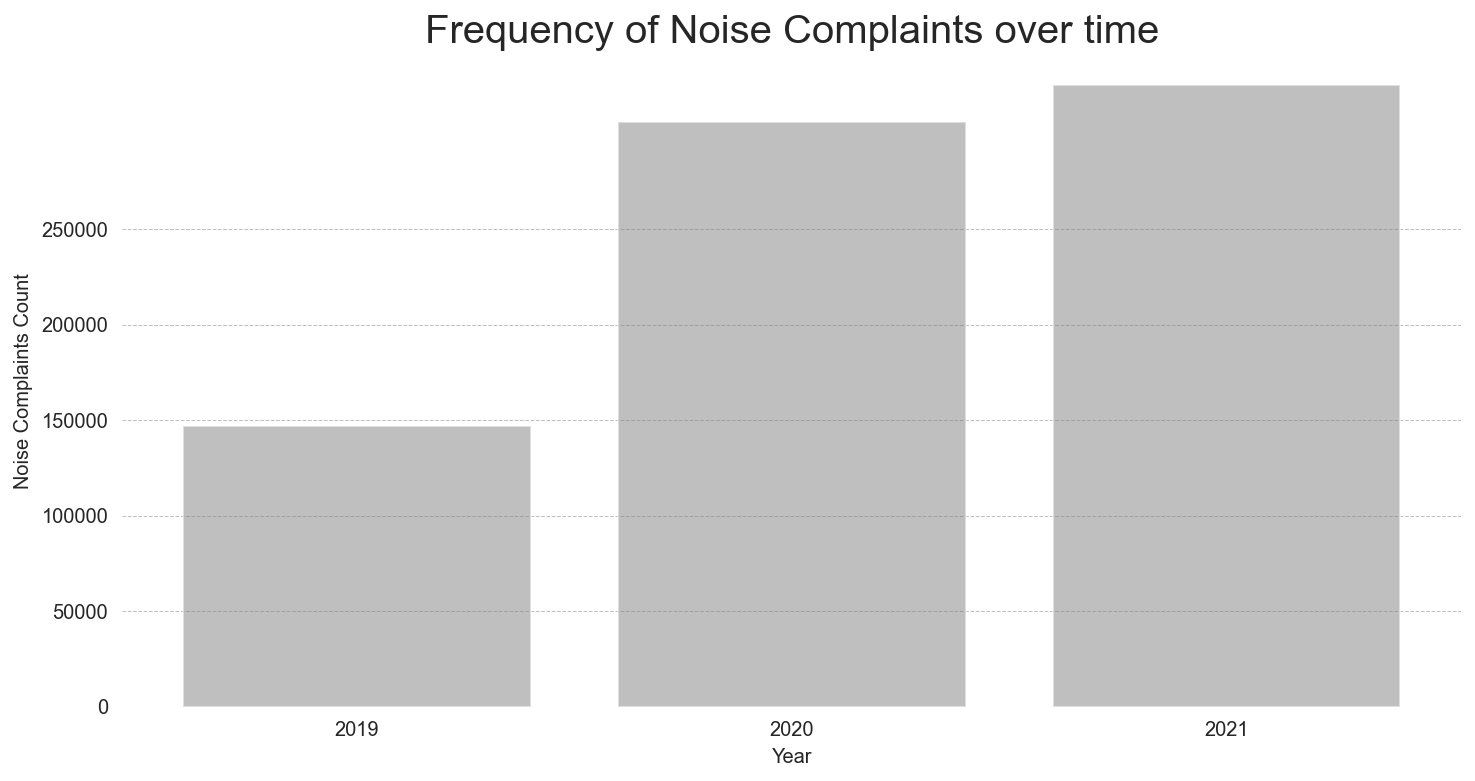

In [30]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Drop 2017 and 2010 as it could be misleading as only few values for the first two months exist
noise_freq_time = noise_freq_time[(noise_freq_time['Created_Year'] != 2017) & (noise_freq_time['Created_Year'] != 2010)]

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y axes
x = noise_freq_time['Created_Year']
y = noise_freq_time['count']

# Give indeces to complaints
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y, align='center', color='grey', alpha=.5)

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0, round(max(y),-5), 50000))
plt.xticks(x_pos, x)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Year")
plt.title("Frequency of Noise Complaints over time",fontsize=20)

# Show the barplot
plt.show()

It is obvious that there was a constant raise in noise complains since 2011 until 2016. Let's create the same **barplot but this time split by noise complain category** and see all 5 category barplots.

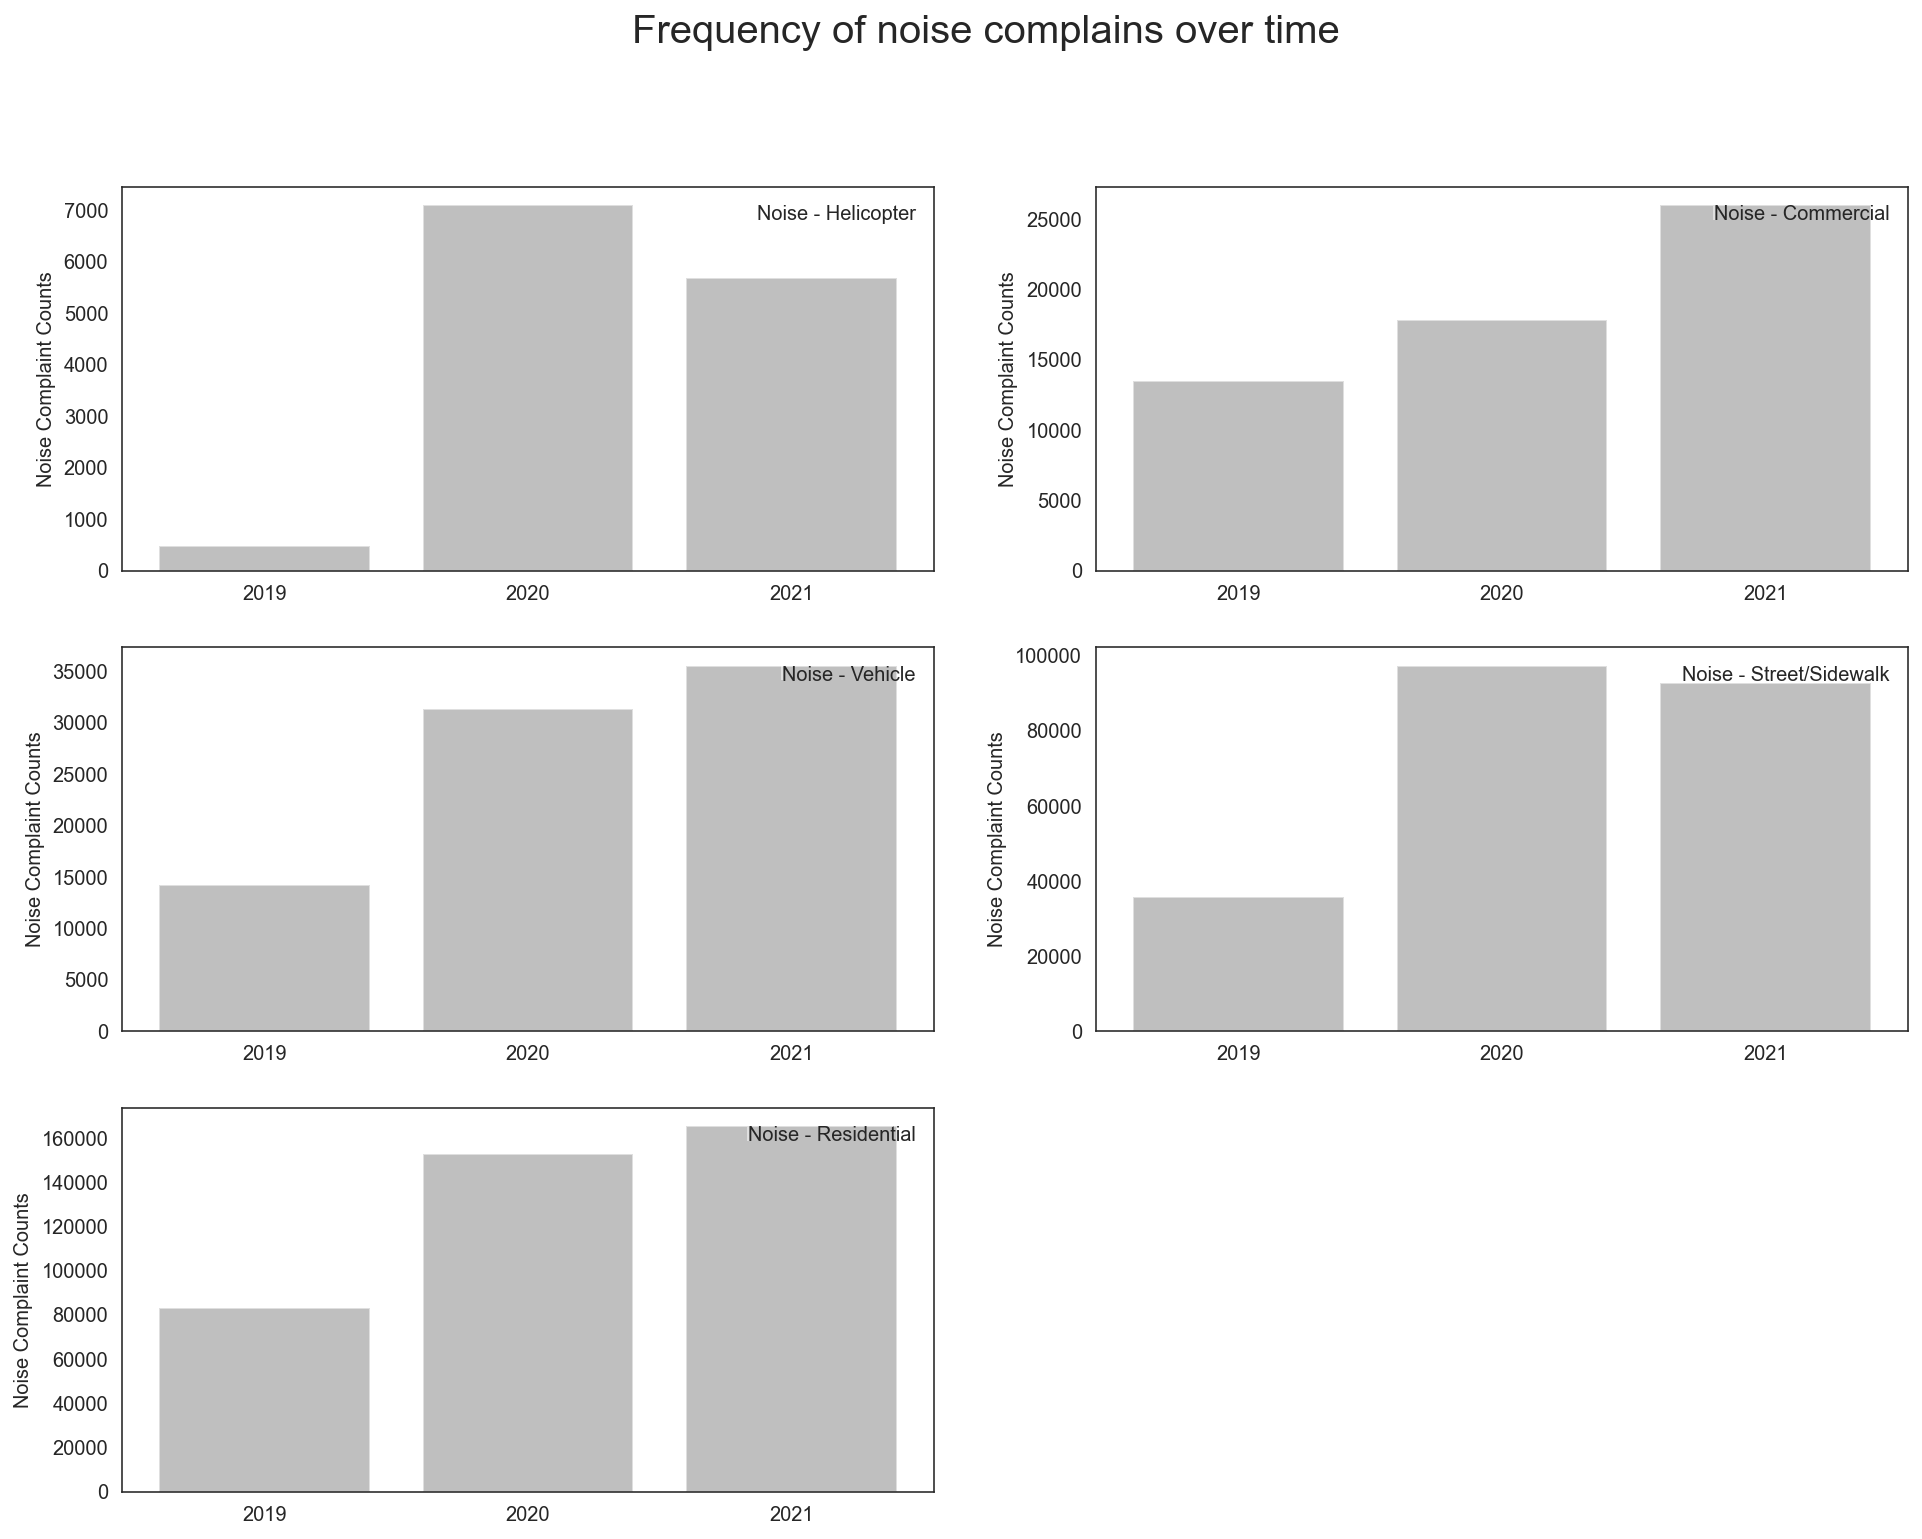

In [31]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(16, 12))
plt.suptitle('Frequency of noise complains over time',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)

    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint_Type'] == complain]

    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created_Year'] != 2017) & (temp_df['Created_Year'] != 2010)]

    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created_Year')['Created_Year'].count().reset_index(
        name='count').sort_values(by='Created_Year', ascending=1)

    # Assign x and y values
    x = occurence['Created_Year']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    plt.bar(x_pos, y, align='center', alpha=.5, color='grey', label=complain)
    plt.xticks(x_pos, x)
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper right', frameon=False,
               handlelength=0, handletextpad=0)

# Show the barplot
plt.show()

In [32]:
# List the number of noise complaints per hour
noise_freq_hour = df_noise.groupby('Created_Hour')['Created_Hour'].count().reset_index(
    name='count').sort_values(by='Created_Hour', ascending=1)
noise_freq_hour

,Created_Hour,count
0,0,84439
1,1,58187
2,2,35213
3,3,21280
4,4,12924
5,5,7849
6,6,6252
7,7,6060
8,8,6892
9,9,8385


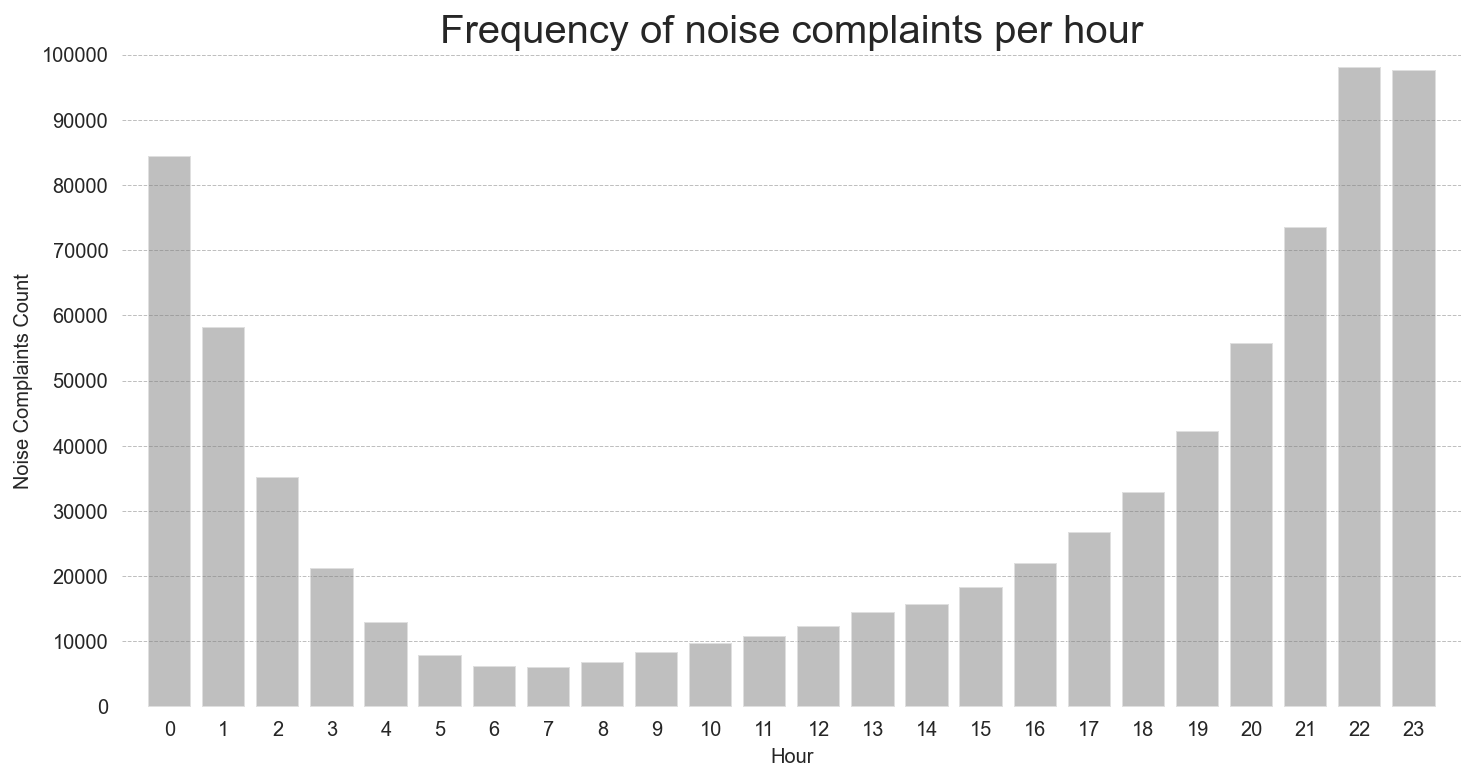

In [33]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = noise_freq_hour['Created_Hour']
y = noise_freq_hour['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x, y, align='center', color='grey', alpha=.5)

# Create ticks
plt.xticks(range(0, 24, 1))
plt.yticks(np.arange(round(min(y),-5), round(max(y),-5)+50000, 10000))
plt.margins(0.02)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Hour")
plt.title("Frequency of noise complaints per hour",fontsize=20)

# Show the barplot
plt.show()

We see that people are bothered by noise usually during sleeping hours. **Since 20 at night to 02** in the morning is the time span with the most complaints. Last step is to **split the same plot per noise complaint type** as we did before for years.

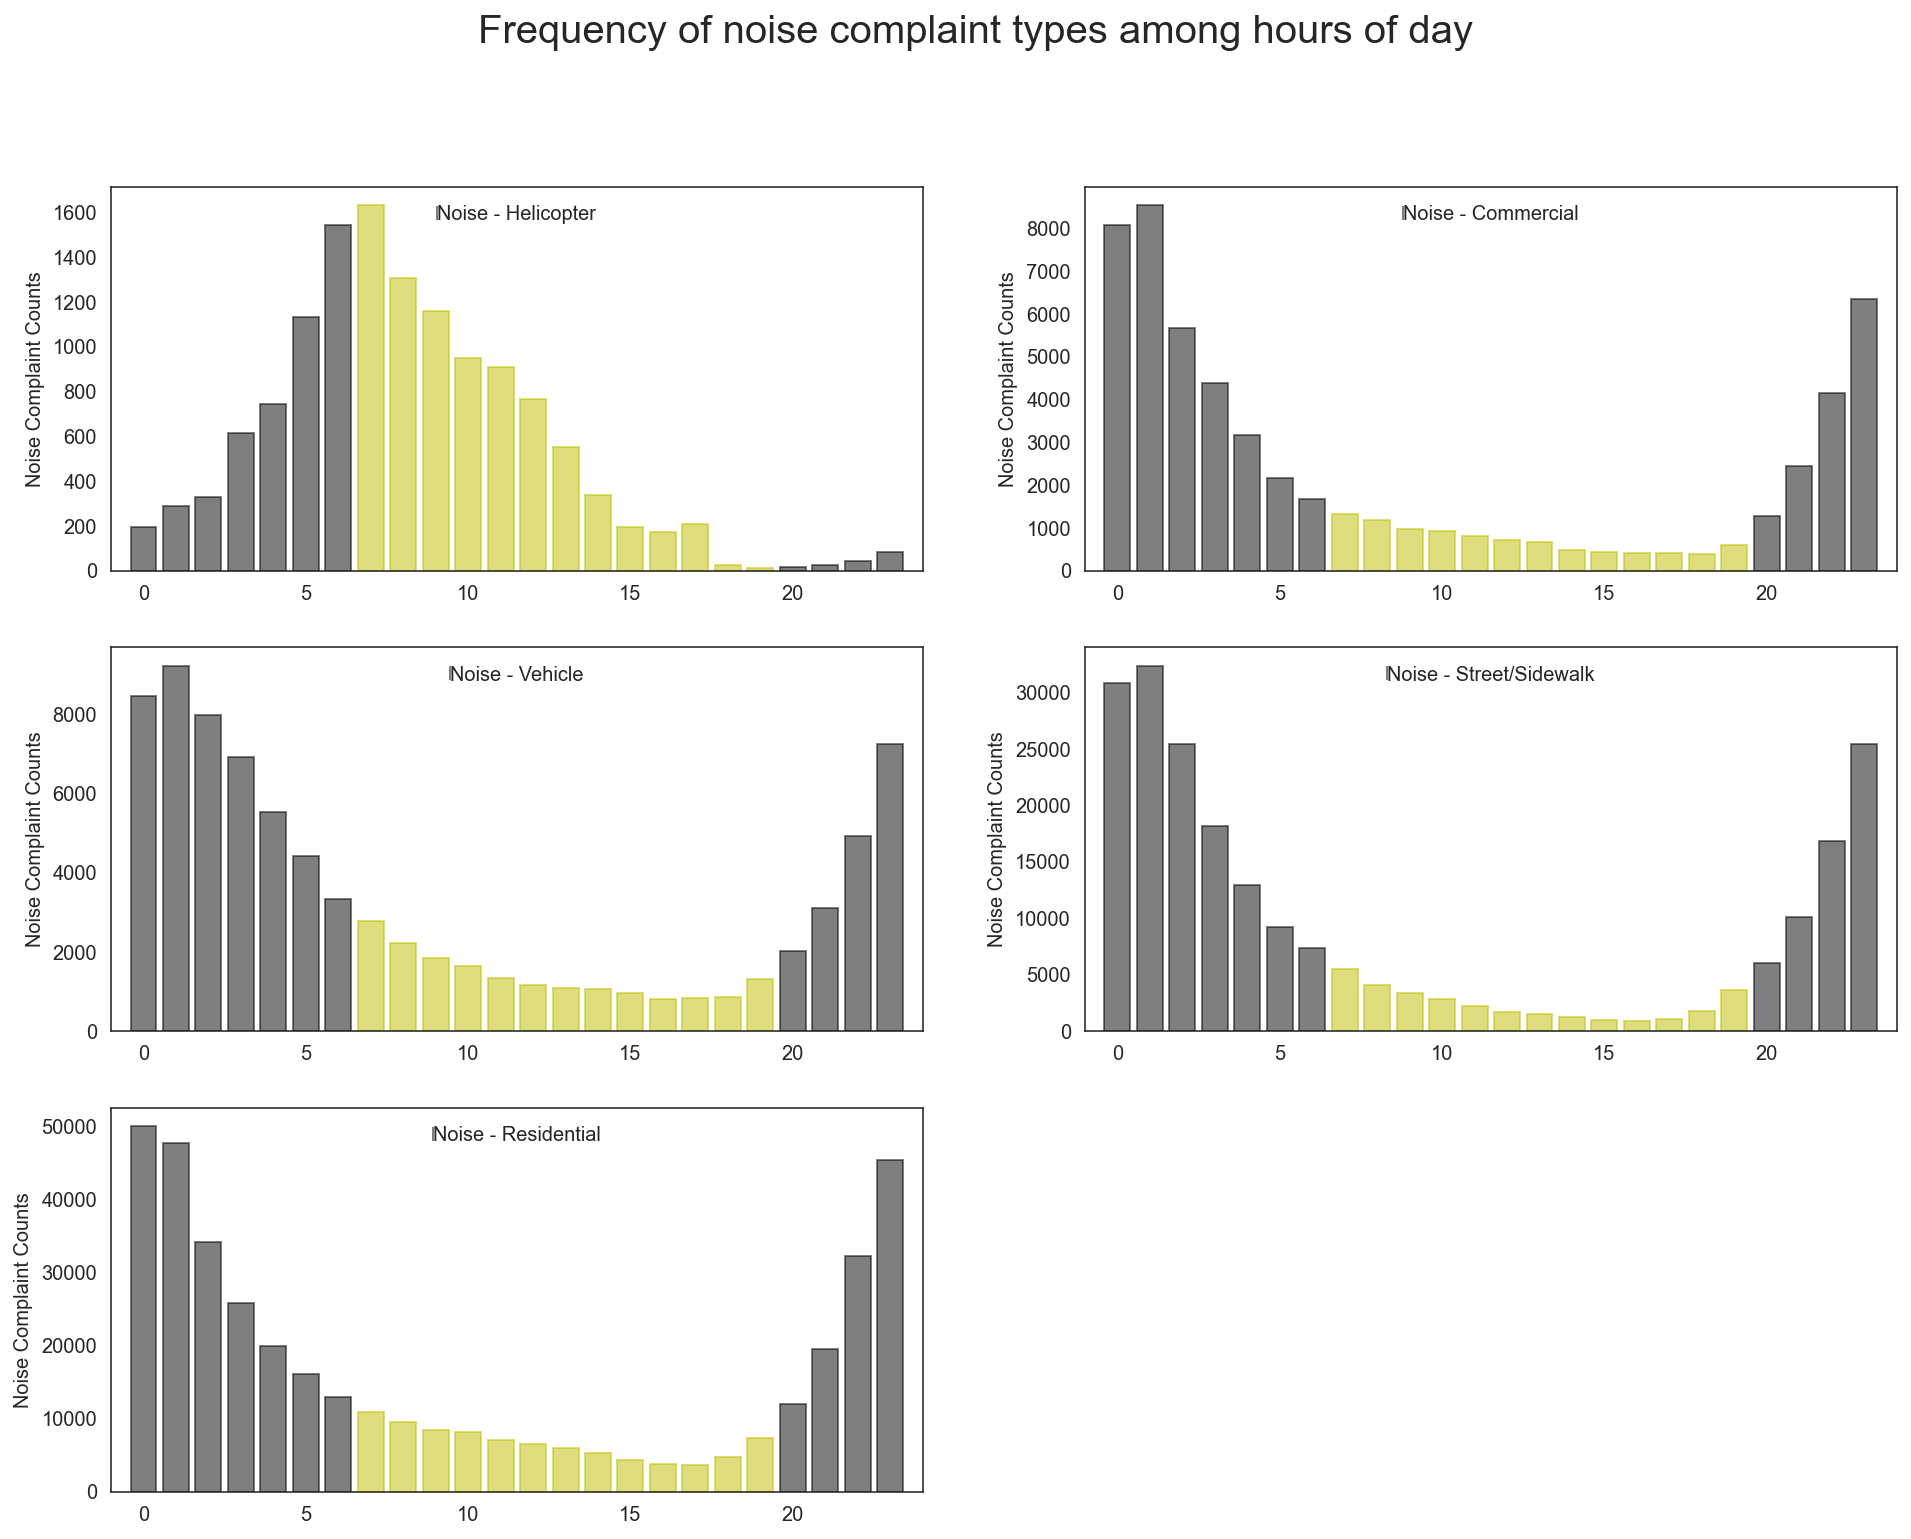

In [34]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (16,12))
plt.suptitle('Frequency of noise complaint types among hours of day',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)
     
    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint_Type'] == complain]
    
    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created_Year'] != 2017) & (temp_df['Created_Year'] != 2010)]
    
    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created_Hour')['Created_Hour'].count().reset_index(name='count').sort_values(by='Created_Hour', ascending=False)
    
    # Assign x and y values
    x = occurence['Created_Hour']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    bars = plt.bar(x_pos,y,align='center',alpha=.5, color='grey',label=complain)
    # Distinguise day hours with different color 
    for i,bar in enumerate(bars):
        if (i>=0 and i<7) or i>=20:
            bar.set_color('k')
        else:
            bar.set_color('y')
        
    plt.xticks(np.arange(0,24,5))
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper center',frameon=False,handlelength=0, handletextpad=0)
    plt.xlim(-1,24)
    
# Show the barplot

plt.show()

It is obviously seen that all noise complaint types have the same pattern. Less complaints in day hours (yellow bars) and more in night hours (gray bars).

## The types of noise complaints and how they take place across NYC

So now we'll be combining information about City and Complaint Type to explore differences between NYC's neighborhoods. First, simply list the names of NYC's **districts**.
因此，现在我们将结合城市和投诉类型的信息，探讨纽约市各区之间的差异。首先，简单列出纽约市**区的名称。

In [35]:
# Create a list of unique values of districts excluding nulls
districts = [i for i in df_noise['City'].unique() if pd.notnull(i)]
print ('The %d districts of NYC are: \n%s' % (len(districts), districts))

The 48 districts of NYC are: 
['NEW YORK', 'RIDGEWOOD', 'BRONX', 'BROOKLYN', 'OZONE PARK', 'REGO PARK', 'FLUSHING', 'ASTORIA', 'STATEN ISLAND', 'KEW GARDENS', 'LONG ISLAND CITY', 'JAMAICA', 'WOODSIDE', 'LITTLE NECK', 'CORONA', 'ELMHURST', 'MASPETH', 'WOODHAVEN', 'EAST ELMHURST', 'JACKSON HEIGHTS', 'FRESH MEADOWS', 'FAR ROCKAWAY', 'ARVERNE', 'SOUTH RICHMOND HILL', 'HOLLIS', 'SOUTH OZONE PARK', 'CAMBRIA HEIGHTS', 'RICHMOND HILL', 'QUEENS VILLAGE', 'FOREST HILLS', 'ROSEDALE', 'GLEN OAKS', 'COLLEGE POINT', 'BELLEROSE', 'WHITESTONE', 'SPRINGFIELD GARDENS', 'MIDDLE VILLAGE', 'SAINT ALBANS', 'SUNNYSIDE', 'BAYSIDE', 'HOWARD BEACH', 'NEW HYDE PARK', 'OAKLAND GARDENS', 'FLORAL PARK', 'BREEZY POINT', 'ROCKAWAY PARK', 'CENTRAL PARK', 'QUEENS']


We will explore which districts have the **most noise complaints**.

In [36]:
# Keep only the Category and the District column
df_noise_district = df_noise.filter(items=['Complaint_Type', 'City'])
df_noise_district = df_noise_district[df_noise_district['City'].isin(districts)]

# List the number of crimes per District
complaint_freq_dist = df_noise_district.groupby('City')['City'].count(
).reset_index(name='count').sort_values(by='count', ascending=0)

# Print the district with the most crimes
print ('The districts with the most noise complains are:\n')
complaint_freq_dist = complaint_freq_dist.reset_index().drop('index',
                                                                         axis=1)
complaint_freq_dist[:5]

The districts with the most noise complains are:



,City,count
0,BRONX,222220
1,BROOKLYN,206561
2,NEW YORK,199481
3,STATEN ISLAND,17128
4,JAMAICA,15388


In [56]:
complaint_freq_dist

,City,count
0,BRONX,222220
1,BROOKLYN,206561
2,NEW YORK,199481
3,STATEN ISLAND,17128
4,JAMAICA,15388
5,ASTORIA,12475
6,RIDGEWOOD,11743
7,CORONA,7844
8,FLUSHING,5734
9,SOUTH RICHMOND HILL,5465


Keep the **most noisy districts** in a seperate list.

In [57]:
noisy_districts = [i for i in complaint_freq_dist['City'][:45]]

Next, we want to generate a slightly more complicated graphic. We are interested to know if there are certain complaints that happen much more in certain neighborhoods than what's typical.    
First, we need to calculate the relative probabilities of seeing each type of noise complaint in the dataset as a whole. We will call it **P(complaint)**
接下来，我们想生成一个稍微复杂的图形。我们有兴趣知道，是否有某些投诉在某些社区发生得比典型的要多。   
首先，我们需要计算在整个数据集中看到每种类型的噪声投诉的相对概率。我们将其称为**P（投诉）**。

In [58]:
# Create one more column with the relative probability of seeing each type of noise complaint
noise_freq['P(complaint)'] = noise_freq['count']/noise_freq['count'].sum()
noise_freq

,Complaint_Type,count,P(complaint)
0,Collection Truck Noise,115,0.000146
1,Noise - House of Worship,679,0.000861
2,Noise - Park,9566,0.012132
3,Noise - Helicopter,13245,0.016799
4,Noise - Commercial,57291,0.072662
5,Noise - Vehicle,81024,0.102762
6,Noise - Street/Sidewalk,225765,0.286336
7,Noise - Residential,400778,0.508303


In [59]:
# Create one more column with the relative probability of seeing each type of noise complaint
noise_freq['P(complaint)'] = noise_freq['count']/noise_freq['count'].sum()
noise_freq

,Complaint_Type,count,P(complaint)
0,Collection Truck Noise,115,0.000146
1,Noise - House of Worship,679,0.000861
2,Noise - Park,9566,0.012132
3,Noise - Helicopter,13245,0.016799
4,Noise - Commercial,57291,0.072662
5,Noise - Vehicle,81024,0.102762
6,Noise - Street/Sidewalk,225765,0.286336
7,Noise - Residential,400778,0.508303


Next, we calculate that same probability distribution but for each NYC district, let's call that **P(complaint|district)**.

In [60]:
# Keep only the Noise complaint types and the Districts in a seperate dataframe
df_noise_2 = df_noise.filter(items=['Complaint_Type', 'City'])

# List the number of complaints per District per Category
complaint_freq_mix = df_noise_2.groupby(
    ['Complaint_Type', 'City']).size().reset_index(name='count')

# Create two more columns with the count per district(count_x) and the
# probability(P(complaint|district))
complaint_freq_mix = pd.merge(complaint_freq_mix.groupby('City')['count'].sum().reset_index(),
                                complaint_freq_mix,
                                on='City',
                                how='outer')
complaint_freq_mix['P(complaint|district)'] = complaint_freq_mix['count_y'] / complaint_freq_mix['count_x']
complaint_freq_mix[:5]

,City,count_x,Complaint_Type,count_y,P(complaint|district)
0,ARVERNE,1085,Noise - Commercial,13,0.011982
1,ARVERNE,1085,Noise - Helicopter,2,0.001843
2,ARVERNE,1085,Noise - Residential,821,0.756682
3,ARVERNE,1085,Noise - Street/Sidewalk,215,0.198157
4,ARVERNE,1085,Noise - Vehicle,34,0.031336


Now we look at the ratio **P(complaint|district)/P(complaint)**. That ratio is equal to 1 if the noise comlpaint occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the complaint occurs more frequently within that district. If it's smaller than one, it means that the complaint is rarer within the district in question than in the city as a whole.
现在我们看一下比率**P（投诉|区）/P（投诉）**。如果噪音投诉在一个区和整个城市中发生的水平相同，该比率等于1。如果它大于1，这意味着投诉在该区发生的频率更高。如果它小于1，意味着该投诉在该区比在整个城市更少。

In [61]:
# Merge the two tables created above to do the calculation
df_noise_final = pd.merge(complaint_freq_mix, noise_freq,
                    on='Complaint_Type', how='outer')
df_noise_final = df_noise_final.drop(['count_x', 'count_y', 'count'], axis=1)  # auto-created

# Create a new column with the Ratio
df_noise_final['Ratio'] = df_noise_final['P(complaint|district)'] / df_noise_final['P(complaint)']

# Sort by District
df_noise_final = df_noise_final.sort_values(by='City').reset_index().drop('index', axis=1)
df_noise_final.head(10)

,City,Complaint_Type,P(complaint|district),P(complaint),Ratio
0,ARVERNE,Noise - Commercial,0.011982,0.072662,0.164895
1,ARVERNE,Noise - Vehicle,0.031336,0.102762,0.304942
2,ARVERNE,Noise - Street/Sidewalk,0.198157,0.286336,0.692044
3,ARVERNE,Noise - Helicopter,0.001843,0.016799,0.109731
4,ARVERNE,Noise - Residential,0.756682,0.508303,1.488644
5,ASTORIA,Noise - Commercial,0.228297,0.072662,3.141914
6,ASTORIA,Noise - Residential,0.472946,0.508303,0.930441
7,ASTORIA,Noise - Vehicle,0.101884,0.102762,0.991454
8,ASTORIA,Noise - Street/Sidewalk,0.194389,0.286336,0.678884
9,ASTORIA,Noise - Helicopter,0.002485,0.016799,0.147928


For the most noisy districts **plot these ratios** for the 5 noise complaints.

In [62]:
# Filter out all those lines not included in the 10 noisy districts
df_noise_final_focus = df_noise_final[df_noise_final['City'].isin(noisy_districts)]
df_noise_final_focus.head(5)

,City,Complaint_Type,P(complaint|district),P(complaint),Ratio
0,ARVERNE,Noise - Commercial,0.011982,0.072662,0.164895
1,ARVERNE,Noise - Vehicle,0.031336,0.102762,0.304942
2,ARVERNE,Noise - Street/Sidewalk,0.198157,0.286336,0.692044
3,ARVERNE,Noise - Helicopter,0.001843,0.016799,0.109731
4,ARVERNE,Noise - Residential,0.756682,0.508303,1.488644


IndexError: index 5 is out of bounds for axis 0 with size 5

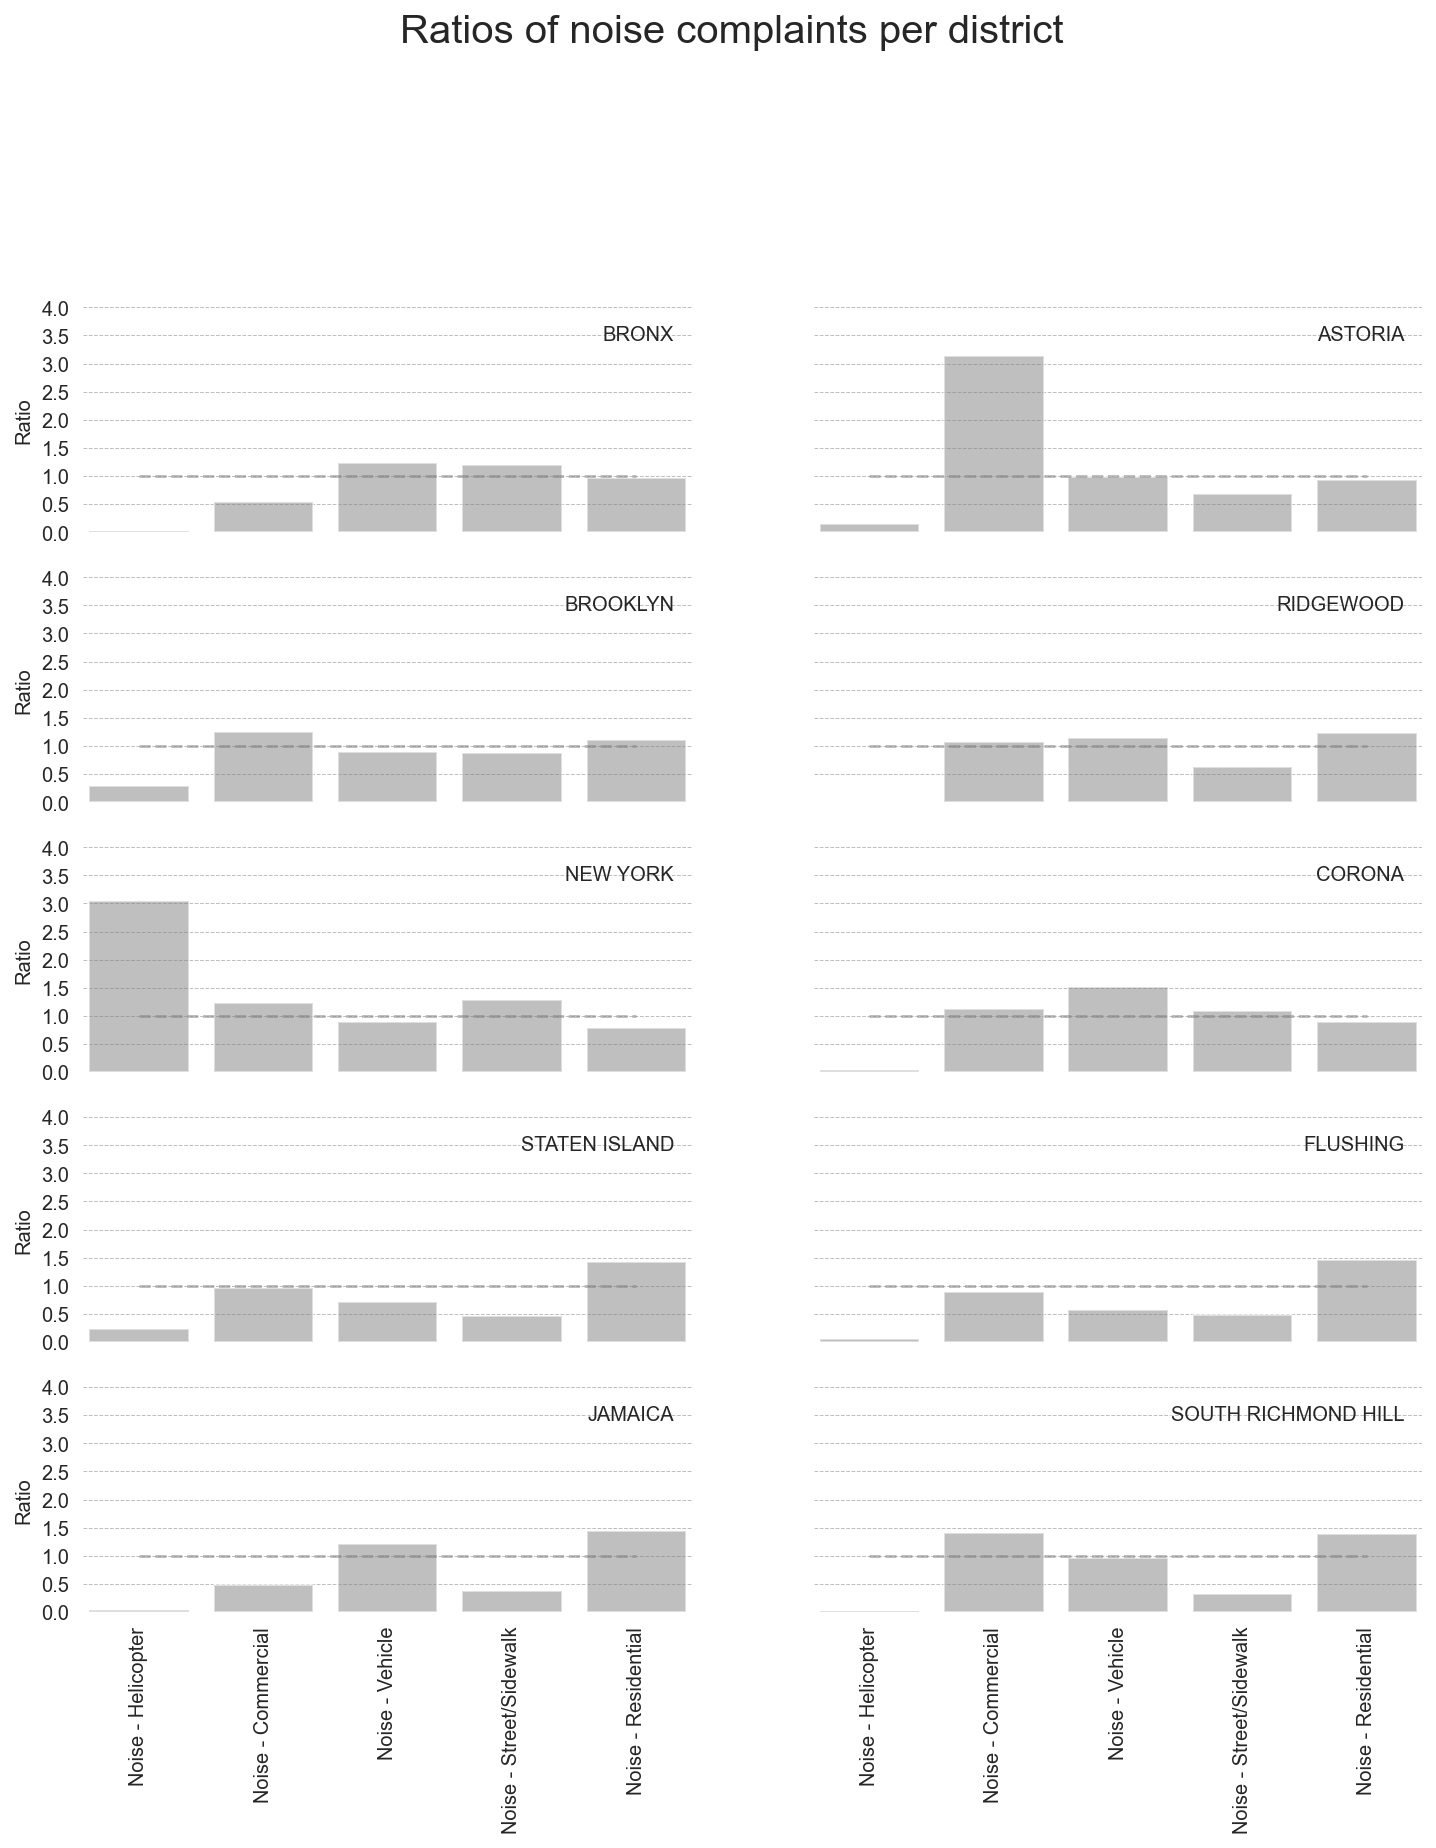

In [63]:
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign variables to axes and figure
fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(12, 12))

# Assign the size and the Super title
fig.suptitle('Ratios of noise complaints per district', fontsize=20, y=1.05)

for index,district in enumerate(noisy_districts):
    # Create a sub-df for each category
    temp_df = df_noise_final_focus[df_noise_final_focus['City']==district]
    
    # Drop columns to minimize the memory usage(optional)
    temp_df = temp_df.drop(['City','P(complaint)','P(complaint|district)'], axis=1) # axis=1 means column
    
    # Assign x
    x = list(noise_list)
    # Give indeces to complaint
    x_pos = np.arange(len(x))
    
    # Assign y and keep the same sorting for each plot
    mapping = {complaint:i for i,complaint in enumerate(x)}
    key = temp_df['Complaint_Type'].map(mapping)
    temp_df = temp_df.iloc[key.argsort()]
    y = temp_df['Ratio']
    
    # Assign x and y to subplots                   
    subindex = 0
    # Index < 5 means left column else right column
    if index < 5:
        final_index = index
        final_subindex = subindex
    else:
        final_index = index - 5
        final_subindex = subindex + 1
    
    # Create an ax object
    ax_temp =  ax[final_index][final_subindex]
    
    # Create a series of grey dashed lines across the each
    # labled y-value of the graph
    ax_temp.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)  
    # Feed the ax object with the x and y values
    ax_temp.bar(x_pos,y,align='center',alpha=.5, color='grey',label=district)
    ax_temp.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    ax_temp.margins(0.01)
    # Draw a threshold line
    ax_temp.plot(x_pos, [1 for _ in range(len(x_pos))], linestyle='--', color = 'grey', alpha = .5)
    # i for i in range(len(x_pos) + 1)
    # 
    
    # get rid of borders for our graph using seaborn's despine function
    sns.despine(top=1, right=1, left=1, bottom=1)
    
    # Set the rotation to vertical
    for tick in ax_temp.get_xticklabels():
        tick.set_rotation(90)
    # Set Ratio label only in the left column
    if index < 5:
        ax_temp.set_ylabel("Ratio")
            
    # Set xticks and yticks parameters
    plt.setp(ax, xticks=x_pos, xticklabels=x,yticks=np.arange(0,4.5,0.5)) 
# Show the barplot
fig.tight_layout()
plt.show()

As seen on the above boxplots there are some bars that reach above the **threshold (Ratio = 1)** and some that are way below it. For example in **ASTORIA** district there is a high ratio of **Commercial Noise** which means that in comparison to the rest of the noise complaints, commercial is the one with the highest impact in ASTORIA.

## Predict the destrict of noise complaints using Decision Tree Classifier

In [64]:
# Focus only on the 10 noisy districts
df_noise_focus = df_noise[df_noise['City'].isin(noisy_districts)]

In [65]:
# Encode categorical variables to digits
le = LabelEncoder()
X = le.fit_transform(df_noise_focus['Complaint_Type'])  
Y = le.fit_transform(df_noise_focus['City'])

In [66]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [67]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train[:,None], Y_train[:,None])
# Predict the testing features
pred = clf.predict(X_test[:,None])

We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.


In [68]:
pred = le.inverse_transform(pred)
Y_test_inv = le.inverse_transform(Y_test)

We calculate the fraction of correct predictions.

In [69]:
print ('Fraction of correct predictions : %.2f%%' % (clf.score(X_test[:,None],Y_test[:,None])*100))

Fraction of correct predictions : 31.73%


这意味着，如果我们只用噪声类型来拟合，我们的分类器在预测正确的地区方面并不那么可靠。但是**如果我们把训练/预测限制在单个地区**（例如，预测BRONX与所有其他地区），我们会看到分类器的不同得分。
Which means that our classifier is not that reliable to predict the correct district if we only fit it with the noise type. But **if we restrict the training/prediction to single districts** (for example, predicting BRONX vs. all other districts) we will see a different score for the classifier.

In [70]:
del df_binary_districts

In [71]:
# Remove pandas loc warning
pd.options.mode.chained_assignment = None

#Function to get the binary representation of a specific value
def get_binary_repr(value,district):
    if value==district:
        return district
    return 'NOT'+district

# Initiate PrettyTable
x = PrettyTable(field_names=['District','Correct Prediction'])
for district in noisy_districts:
    df_binary_districts = df_noise_focus
    df_binary_districts['District_Bin'] = df_binary_districts['City'].apply(lambda x: get_binary_repr(x,district))

    # Split training and testing data (N.B. X is the same as before)
    Y_new = df_binary_districts['District_Bin']
    Y_new = le.fit_transform(Y_new)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=0.1, random_state=0)
    
    #Train classifier and predict
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[:,None], Y_train[:,None])

    #Calculate fraction of correct predictions
    x.add_row([district,str(clf.score(X_test[:,None],Y_test[:,None])*100)[:5]+'%'])
    
print (x)

+---------------------+--------------------+
|       District      | Correct Prediction |
+---------------------+--------------------+
|        BRONX        |       71.59%       |
|       BROOKLYN      |       73.45%       |
|       NEW YORK      |       75.07%       |
|    STATEN ISLAND    |       97.72%       |
|       JAMAICA       |       98.01%       |
|       ASTORIA       |       98.40%       |
|      RIDGEWOOD      |       98.54%       |
|        CORONA       |       99.00%       |
|       FLUSHING      |       99.26%       |
| SOUTH RICHMOND HILL |       99.34%       |
|     FAR ROCKAWAY    |       99.35%       |
|       ELMHURST      |       99.36%       |
|   LONG ISLAND CITY  |       99.42%       |
|       WOODSIDE      |       99.42%       |
|   JACKSON HEIGHTS   |       99.43%       |
|    FRESH MEADOWS    |       99.43%       |
|      OZONE PARK     |       99.46%       |
|   SOUTH OZONE PARK  |       99.48%       |
|      WOODHAVEN      |       99.50%       |
|    COLLE

这是一个相当酷的图片。我们可以很容易地预测并依赖我们的预测，一个特定的噪音投诉将发生在一个特定的区。但是，让我们在地图上**出所有噪音投诉的不同颜色。
This is a pretty cool picture. We can easily predict and rely in our prediction that a specific noise complaint will occur in a specific borough. But let's **plot on a map** all noise complaints in different color.

### Plot noise complains on map (only noisy districts)

Firstly, we should check for outliers in the coordinates dataset.

In [72]:
#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_noise_focus['Latitude'])]
longs = [float(el) for el in list(df_noise_focus['Longitude'])]
print ('Latitudes:',set([round(el) for el in lats]))
print ('Longitudes:',set([round(el) for el in longs]))

Latitudes: {40, 41}
Longitudes: {-74}


Longs和Lats似乎很正常，没有异常值。现在我们已经准备好将每个投诉作为一个点绘制在地图上。但在此之前，我们应该**创建一个字典**（对**geoplotlib库来说是必须的），有两个键（lat和lon）和两个列表作为每个键的值（坐标列表）。

Longs and Lats seem normal with no outliers. Now we are ready to plot each complain as a point on a map. But before that, we should **create a dictionary**(mandatory for the **geoplotlib library**) with two keys(lat and lon) and two lists as values of each key(lists of coordinates).

In [73]:
# Create dictionary and put each complaint's coordinates as a seperate key,value pair
geo_dict = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_focus[df_noise_focus['Complaint_Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_focus[df_noise_focus['Complaint_Type']==complaint]['Longitude'])]}
    geo_dict[complaint] = geo_data_for_plotting

And now we are fully ready for plotting the complains with different color per noise complain type on a map.

In [74]:
#Let's define a function for plotting the dot map, as it will be used later
def dot_plot(geo_dict,size):
    colors = ['white', 'black', 'red', 'green', 'blue','yellow']

    for i,complaint in enumerate(noise_list):
        # Create a legend
        print ('%s\t\t ----->\t\t%d observations\t ----->\t%s' % (colors[i],len(geo_dict[complaint]['lon']),complaint))
        # Fit the map with dots
        geoplotlib.dot(geo_dict[complaint], color=colors[i], point_size=size)

    # Create an BoundigBox for the limits of the map
    bbox = BoundingBox(north=max(geo_dict[complaint]['lat']),
                       west=min(geo_dict[complaint]['lon']),
                       south=min(geo_dict[complaint]['lat']),
                       east=max(geo_dict[complaint]['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.show()
    
dot_plot(geo_dict,.6)

white		 ----->		13245 observations	 ----->	Noise - Helicopter
black		 ----->		57269 observations	 ----->	Noise - Commercial
red		 ----->		81023 observations	 ----->	Noise - Vehicle
green		 ----->		225763 observations	 ----->	Noise - Street/Sidewalk
blue		 ----->		400730 observations	 ----->	Noise - Residential


### Predict the district of noise complaints using KNN classifier

根据上述情况，分类器将更有可能把那些密度高的点（蓝色--住宅噪声）与那些密度低的点（黑色--公园噪声）放在一起。下面我们通过对每个类别采取相同数量的随机样本，得到一个**的平衡数据集。

In [77]:
num_samples = 5000 #Number of random samples to extract

# Randomly extract a balanced number of samples
df_noise_bal = pd.DataFrame(columns = ['Complaint_Type','Longitude','Latitude'])
for complaint in noise_list:
    sample = df_noise_focus[df_noise_focus['Complaint_Type']==complaint].sample(n=num_samples).filter(items=['Complaint_Type','Longitude','Latitude'])
    df_noise_bal = pd.concat([sample,df_noise_bal])

After creating the **balanced dataset** is should sum up to 10000 lines(2000 lines for each of the 5 noise type complaints). Let's be sure that the sampling worked correctly. 

In [78]:
len(df_noise_bal)

25000

Let's plot the **balanced map** and check the distribution of points before fitting the classifier. Firstly we should create a new balanced dictionary for the **geoplotlib** library.
让我们在拟合分类器之前绘制**平衡图并检查点的分布。首先我们应该为**geoplotlib**库创建一个新的平衡字典。

In [79]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_bal = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_bal[df_noise_bal['Complaint_Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_bal[df_noise_bal['Complaint_Type']==complaint]['Longitude'])]}
    geo_dict_bal[complaint] = geo_data_for_plotting

In [80]:
dot_plot(geo_dict_bal,1)

white		 ----->		5000 observations	 ----->	Noise - Helicopter
black		 ----->		5000 observations	 ----->	Noise - Commercial
red		 ----->		5000 observations	 ----->	Noise - Vehicle
green		 ----->		5000 observations	 ----->	Noise - Street/Sidewalk
blue		 ----->		5000 observations	 ----->	Noise - Residential


现在我们已经准备好用平衡的数据集来拟合分类器。但是为了区分将从分类器中创建的集群，我们应该首先创建一个大约**平方的网格，该网格的点贯穿于纽约市。网格的大小将是**100x100**（共10000个点）。

Now we are ready to fit the classifier with the balanced dataset. But in order to distinguise the clusters that will be created from the classifiers we should first create an approximately **square grid** of point that runs over NYC. The size grid will be **100x100**(10000 points in total). 

In [81]:
def grid_creator(df_data,grid_size):
    '''Create a grid of XxY'''
    # Define grid size
    grid_size = grid_size

    #Generating all the coordinates of the points contained in the grid
    min_lat = float(min(df_data['Latitude']))
    max_lat = float(max(df_data['Latitude']))
    min_lon = float(min(df_data['Longitude']))
    max_lon = float(max(df_data['Longitude']))
    all_lats = np.arange(min_lat,max_lat,(max_lat-min_lat)/grid_size)
    all_longs = np.arange(min_lon,max_lon,(max_lon-min_lon)/grid_size)

    #List of tuples representing points, generated combining all possible values of latitudes/longitudes
    all_points = set() #Created as set, to be sure it won't contain duplicates
    for lat in all_lats:
        for lon in all_longs:
            all_points.add((lat,lon)) #each coordinate saved as a tuple
    all_points = list(all_points)

    all_grid_points = {'lat': [el[0] for el in all_points],
                       'lon':[el[1] for el in all_points]}
    return all_grid_points,all_points

In [82]:
all_grid_points,all_points = grid_creator(df_noise_focus,100)

Below we plotted just an overview of what does the grid look like (before the classification, only raw coordinate points, to make sure it was as expected):
下面我们只画出了网格的概况（在分类之前，只有原始坐标点，以确保它与预期相符）。

In [83]:
geoplotlib.dot(all_grid_points, color='black', point_size=2)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(all_grid_points['lat'])-0.3,
                   west=min(all_grid_points['lon'])+0.3,
                   south=min(all_grid_points['lat'])+0.3,
                   east=max(all_grid_points['lon'])-0.3)
geoplotlib.set_bbox(bbox)
geoplotlib.show()

As it's shown below, we used Object Oriented Programming for Python to create a Layer class, whose concern is to display the title on each plot and plot complex data. We fit the **KNN classifier** inside the invalidate() method and according to the output provided by the prediction we draw each point of the grid with the correct color.
For each number of neighbors we plot the colored grid, in order to see what does this parameter affect concerning the model.
如下图所示，我们使用Python的面向对象编程来创建一个Layer类，其关注点是在每个图上显示标题，并绘制复杂的数据。我们在invalidate()方法里面拟合了**KNN分类器，根据预测提供的输出，我们用正确的颜色绘制网格的每个点。
对于每一个邻居的数量，我们绘制彩色的网格，以便看到这个参数对模型有什么影响。

In [84]:
class KNeighbors_Layer(BaseLayer):

    def __init__(self, data,k,all_grid_points):
        self.data = data #Is the balanced dataframe
        self.k = k # number of neighbors
        self.all_grid_points = all_grid_points #All the coordinate of the grid points

    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        
        # Train the KNN classifier
        features = np.array(self.data[['Latitude','Longitude']]) # Notice that X,Y are reverted by default in the original data frame
        labels = np.array(self.data['Complaint_Type'])
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        print ('Neighbors # %d \t\t ----->\t\t %.2f%% ' % (self.k,(clf.score(features, labels)*100)))
        
        #Prepare the grid points to predict, building matrix
        x, y = proj.lonlat_to_screen(self.all_grid_points['lon'], self.all_grid_points['lat'])
        #Used column stack to concatenate by columns the two arrays and create a 2D array
        grid_points_matrix = np.column_stack((self.all_grid_points['lat'],self.all_grid_points['lon']))
        Z = clf.predict(grid_points_matrix)
        
        # Create colormap per complaint type
        self.cmap = {'Noise - Helicopter':'white','Noise - Commercial':'black','Noise - Vehicle':'red', 
                    'Noise - Street/Sidewalk': 'green', 'Noise - Residential':'blue'}
        for complaint in noise_list:
            self.painter.set_color(self.cmap[complaint])
            self.painter.points(x[Z == complaint], y[Z == complaint], 4) # paints the points according to predicted crimes
    
    # Map interaction
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()

After the definition of the class, we finally plot the different dot maps, each one using a different number of neighbors for the classifier.
在定义完类别后，我们最后绘制不同的点阵图，每个点阵图都使用不同数量的邻居作为分类器。

In [85]:
num_neighbors=[3,5,10,30]
colors = ['white', 'black', 'red', 'green', 'blue']

# Create Legend
print ('********************************\n************ Legend ************\n********************************\n')
for i,complaint in enumerate(noise_list):
    print ('%s\t\t ----->\t\t%s community' % (colors[i],complaint))
print ('---------------------------------------------------------------------\n\n')
print ('*******************************************\n************ Prediction Scores ************\n*******************************************\n')

for k in num_neighbors:
    geoplotlib.add_layer(KNeighbors_Layer(df_noise_bal,k,pd.DataFrame(all_grid_points)))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(all_grid_points['lat'])-0.1,
                   west=min(all_grid_points['lon'])+0.1,
                   south=min(all_grid_points['lat'])+0.1,
                   east=max(all_grid_points['lon'])-0.1)
    geoplotlib.set_bbox(bbox)
    geoplotlib.show()

********************************
************ Legend ************
********************************

white		 ----->		Noise - Helicopter community
black		 ----->		Noise - Commercial community
red		 ----->		Noise - Vehicle community
green		 ----->		Noise - Street/Sidewalk community
blue		 ----->		Noise - Residential community
---------------------------------------------------------------------


*******************************************
************ Prediction Scores ************
*******************************************

Neighbors # 3 		 ----->		 74.38% 
Neighbors # 3 		 ----->		 74.38% 
Neighbors # 3 		 ----->		 74.38% 
Neighbors # 3 		 ----->		 74.38% 
Neighbors # 5 		 ----->		 69.70% 
Neighbors # 5 		 ----->		 69.70% 
Neighbors # 5 		 ----->		 69.70% 
Neighbors # 10 		 ----->		 63.53% 
Neighbors # 30 		 ----->		 56.22% 


## D3 Visualizations

* Create a hidden transparent grid on a map and each time a user press anywhere on map(on click), there will be a tooltip displaying one of the five noise classification types that the KNN classifier suggests.  

In [86]:
# Create a dataframe to fit the data
temp_df = pd.DataFrame(all_grid_points)

In [87]:
# Create a function that adds a column to a grid after applying KNN (k and dataframe as parameter)
def KNN_helper(df_data, k, all_grid_points):
    # Train the KNN classifier
    features = np.array(df_data[['Latitude','Longitude']]) # Notice that X,Y are reverted by default in the original data frame
    labels = np.array(df_data['Complaint_Type'])
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(features, labels)
    
    #Used column stack to concatenate by columns the two arrays and create a 2D array
    grid_points_matrix = np.column_stack((all_grid_points['lat'],all_grid_points['lon']))
    Z = clf.predict(grid_points_matrix)
    if str(k)+'_neighs' not in temp_df.columns:
        temp_df[str(k)+'_neighs'] = Z        
    print ('For K = %d the update is done!'%k)

In [88]:
num_neighbors=[5,10,30]

for k in num_neighbors:
    KNN_helper(df_noise_bal,k,pd.DataFrame(all_grid_points))

For K = 5 the update is done!
For K = 10 the update is done!
For K = 30 the update is done!


In [89]:
# Save it to a csv for D3
temp_df.to_csv('KNN_map.csv', index=False)#记得改列的命名

* Create a csv with top complaint and total complaint count per neighborhood to show on map

In [90]:
# Remove neighborhoods with 1-10 counts due to duplicates
df = df[~df['City'].isin(['CAMBRIA HEIGHS','JERICHO','KEW GARDEN','LIC','MANHATTAN','N.Y','NEWYORK','NY','UNKNOWN'])]

In [91]:
# Create a df for total complaints per neighborhood
total_neight = df['City'].groupby(df['City']).count().sort_values(ascending=False).reset_index(name='count')

In [92]:
# Create a df for top_complaint per neighborhood
x = []
for district in df['City'].unique():
# Create a sub-df for each category
    temp_df = df[df['City'] == district]
    
    # Count frequency of complaint occurence
    x.append([district,temp_df.groupby('Complaint_Type')['Complaint_Type'].count().reset_index(name='count').sort_values(by='count', ascending=0).reset_index()['Complaint_Type'][0]])
new_df = pd.DataFrame(x,columns=['City','top_complaint'])
new_df

,City,top_complaint
0,NEW YORK,Noise - Residential
1,RIDGEWOOD,Noise - Residential
2,BRONX,Noise - Residential
3,BROOKLYN,Noise - Residential
4,OZONE PARK,Noise - Residential
5,REGO PARK,Noise - Residential
6,FLUSHING,Noise - Residential
7,ASTORIA,Noise - Residential
8,STATEN ISLAND,Noise - Residential
9,KEW GARDENS,Noise - Residential


In [93]:
# Merge the above dfs
total_neight = pd.merge(total_neight,new_df,on='City',how='inner')

In [94]:
total_neight

,City,count,top_complaint
0,BRONX,225114,Noise - Residential
1,BROOKLYN,208891,Noise - Residential
2,NEW YORK,202438,Noise - Residential
3,STATEN ISLAND,17221,Noise - Residential
4,JAMAICA,15449,Noise - Residential
5,ASTORIA,12607,Noise - Residential
6,RIDGEWOOD,11846,Noise - Residential
7,CORONA,8265,Noise - Residential
8,FLUSHING,5854,Noise - Residential
9,SOUTH RICHMOND HILL,5469,Noise - Residential


In [95]:
# Save it to a csv for D3
total_neight.to_csv('total_neight.csv', index=False)